# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

$\min \; Z =
\underbrace{
w_{\text{main}} \cdot \left(
w_t \cdot \sum_{j \in \mathcal{J}} T_j
+ w_e \cdot \sum_{j \in \mathcal{J}} E_j
+ w_{\text{first}} \cdot \sum_{j \in \mathcal{J}} F_j
\right)
}_{\text{Lateness-Komponente}}
\; + \;
\underbrace{
(1 - w_{\text{main}}) \cdot \sum_{(j,o) \in \mathcal{P}} D_{jo}
}_{\text{Abweichungskomponente}}$

$\mathcal{J}$ … Menge aller Jobs
$\mathcal{P}$ … Menge aller Operationen mit vorherigem Planbezug

$T_j = \max(0, \text{Ende}_j - \text{Deadline}_j)$ … Tardiness (Verspätung)
$E_j = \max(0, \text{Deadline}_j - \text{Ende}_j)$ … Earliness (zu früh)
$F_j = \max(0, \text{Wunschstart}_j - \text{Start}_{j,0})$ … Frühstartstrafe der ersten Operation

$D_{jo} =
\begin{cases}
|S_{jo}^{\text{neu}} - S_{jo}^{\text{alt}}| & \text{(Startzeitabweichung)} \\
\text{Anzahl der Inversionen (Kendall-Tau)} & \text{(Reihenfolgeabweichung)}
\end{cases}$


In [15]:
import json
import pandas as pd
from decimal import Decimal

from matplotlib import pyplot as plt

# DataFrame analyses
from src.DataFrameAnalyses import DataFramePlotGenerator, DataFrameChecker, DataFrameMetricsAnalyser

# Analysis utils
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.CP_Solver import Solver

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Database and Collections
from src.domain.Query import JobQuery
from src.domain.Collection import LiveJobCollection

In [3]:
# Hard termination condition for schedulers
max_time = 60*10     # 10 min

# File paths
examples_data_path = get_path("data", "examples")
logs_path = get_path("data", "logs")

# Simulation
simulation = ProductionSimulation(shift_length= 1440, sigma = 0.2)

In [4]:
jobs = JobQuery.get_by_source_name_and_max_bottleneck_utilization(
    source_name="Fisher and Thompson 10x10",
    max_bottleneck_utilization=Decimal("0.85"),
)

jobs_collection = LiveJobCollection(jobs)
jobs_collection.to_jobs_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,1440,2746
1,01-08500-0001,01-06,53,1440,2759
2,01-08500-0002,01-01,125,1440,2835
3,01-08500-0003,01-05,174,1440,3912
4,01-08500-0004,01-04,219,1440,3628
5,01-08500-0005,01-02,443,1440,3168
...,...,...,...,...,...
7646,01-08500-7646,01-07,577068,577440,579349
7647,01-08500-7647,01-06,577077,577440,578784
7648,01-08500-7648,01-08,577128,577440,578982


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# New jobs that must be scheduled
current_jobs_collection = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)


In [7]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,M02,None,31,None,0,1440,2746
1,01-08500-0000,01-07,1,M00,None,86,None,0,1440,2746
2,01-08500-0000,01-07,2,M01,None,46,None,0,1440,2746
3,01-08500-0000,01-07,3,M05,None,74,None,0,1440,2746
4,01-08500-0000,01-07,4,M04,None,32,None,0,1440,2746
5,01-08500-0000,01-07,5,M06,None,88,None,0,1440,2746
...,...,...,...,...,...,...,...,...,...,...
154,01-08500-0015,01-01,4,M03,None,69,None,1437,1440,3089
155,01-08500-0015,01-01,5,M01,None,28,None,1437,1440,3089
156,01-08500-0015,01-01,6,M06,None,46,None,1437,1440,3089


In [8]:
df_jobs_times_current = current_jobs_collection.to_jobs_dataframe()
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,1440,2746
1,01-08500-0001,01-06,53,1440,2759
2,01-08500-0002,01-01,125,1440,2835
3,01-08500-0003,01-05,174,1440,3912
4,01-08500-0004,01-04,219,1440,3628
5,01-08500-0005,01-02,443,1440,3168
6,01-08500-0006,01-00,753,1440,3570
7,01-08500-0007,01-03,896,1440,3379
8,01-08500-0008,01-09,962,1440,2689
9,01-08500-0009,01-08,979,1440,3402


### Scheduling

In [9]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)
solver.build_model_for_jssp_lateness_with_start_deviation_minimization(
    previous_schedule_jobs_collection=None,
    active_jobs_collection=None,
    w_t = 5, w_e = 1, w_first = 1,
    duration_buffer_factor= 2.5
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

w_t=5, w_e=1, w_first=1 main_pct=1.0
{
  "number_of_operations_to_schedule": 160,
  "number_of_operations_with_previous_schedule": 0,
  "number_of_active_operation_to_consider": 0,
  "number_of_variables": 421,
  "number_of_constraints": 431
}


In [10]:
log_file_path = logs_path / "cp_lateness_with_w_first_init.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))

{
  "status": "OPTIMAL",
  "objective_value": 0.0,
  "best_objective_bound": 0.0,
  "number_of_branches": 42,
  "wall_time": 0.04
}


In [11]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_01.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,M02,1440,31,1471,0,1440,2746
1,01-08500-0000,01-07,1,M00,1471,86,1557,0,1440,2746
2,01-08500-0000,01-07,2,M01,1616,46,1662,0,1440,2746
3,01-08500-0000,01-07,3,M05,1662,74,1736,0,1440,2746
4,01-08500-0000,01-07,4,M04,1736,32,1768,0,1440,2746
5,01-08500-0000,01-07,5,M06,1768,88,1856,0,1440,2746
...,...,...,...,...,...,...,...,...,...,...
154,01-08500-0015,01-01,4,M03,2207,69,2276,1437,1440,3089
155,01-08500-0015,01-01,5,M01,2276,28,2304,1437,1440,3089
156,01-08500-0015,01-01,6,M06,2304,46,2350,1437,1440,3089


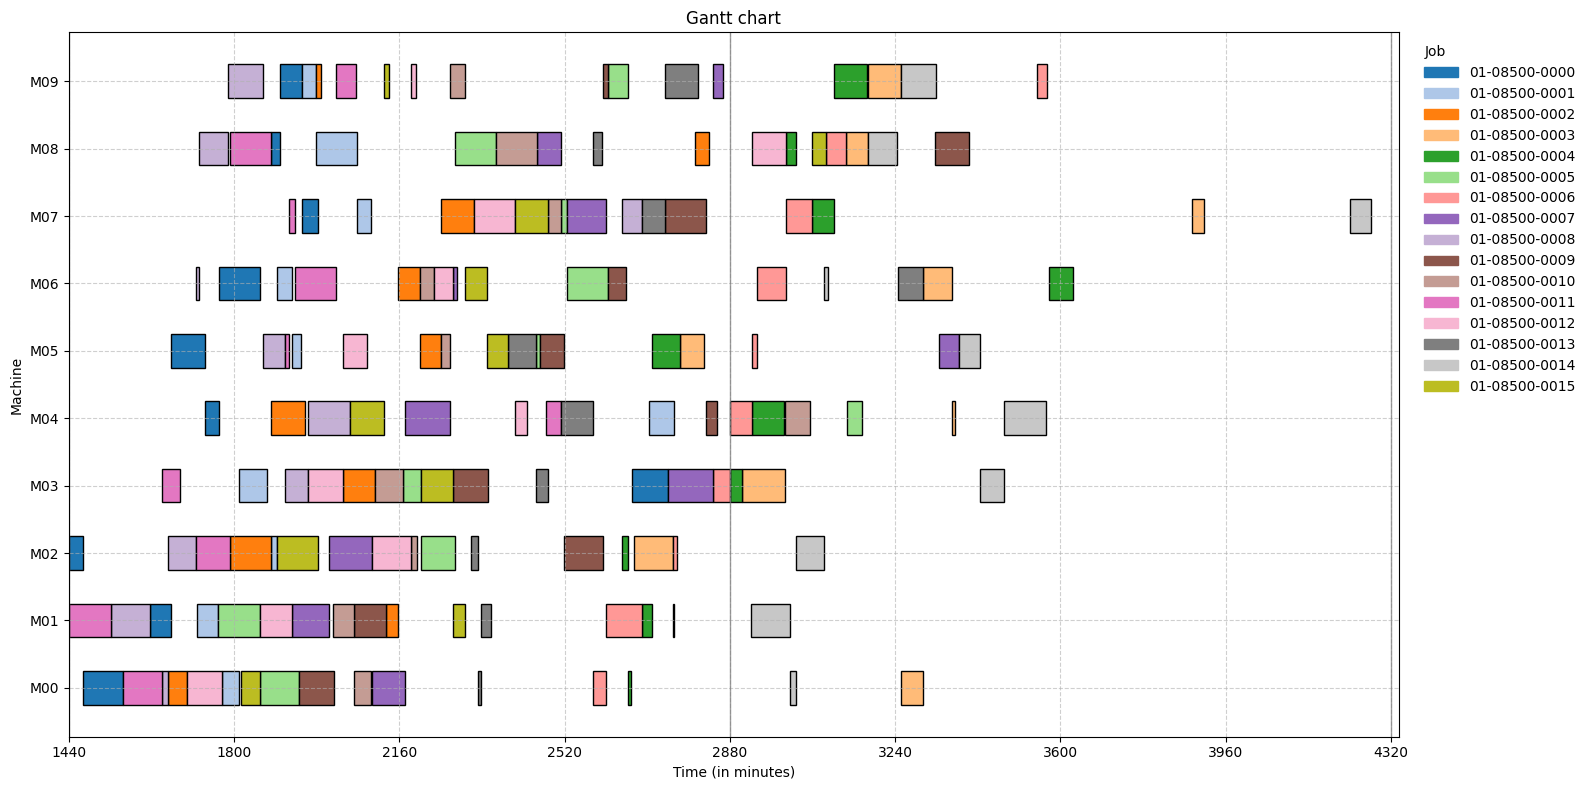

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [16]:
DataFramePlotGenerator.get_gantt_chart_figure(df_schedule, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_schedule)
DataFrameChecker.is_duration_correct(df_schedule)


In [17]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
df_jobs_metrics

,Job,Routing_ID,Last Operation,End,Arrival,Ready Time,Due Date,Total Processing Time,Flowtime,Lateness,Tardiness,Earliness
0,01-08500-0000,01-07,9,2746,0,1440,2746,539,1306,0,0,0
1,01-08500-0001,01-06,9,2759,53,1440,2759,416,1319,0,0,0
2,01-08500-0002,01-01,9,2835,125,1440,2835,510,1395,0,0,0
3,01-08500-0003,01-05,9,3912,174,1440,3912,496,2472,0,0,0
4,01-08500-0004,01-04,9,3628,219,1440,3628,393,2188,0,0,0
5,01-08500-0005,01-02,9,3168,443,1440,3168,568,1728,0,0,0
6,01-08500-0006,01-00,9,3570,753,1440,3570,395,2130,0,0,0
7,01-08500-0007,01-03,9,3379,896,1440,3379,655,1939,0,0,0
8,01-08500-0008,01-09,9,2689,962,1440,2689,540,1249,0,0,0
9,01-08500-0009,01-08,9,3402,979,1440,3402,597,1962,0,0,0


In [18]:
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,16,0,0,0


In [19]:
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,0,16,0,0,0


### Simulation

In [20]:
# simulation.run(schedule_collection = schedule_jobs_collection, start_time = day_start, end_time=day_end)
simulation.initialize_run(schedule_collection = schedule_jobs_collection, start_time=day_start)

[Day 1 00:00:00] Job 01-08500-0000 started on M02
[Day 1 00:00:00] Job 01-08500-0011 started on M01
[Day 1 00:24:00] Job 01-08500-0000 finished on M02 (after 24 minutes)
[Day 1 00:31:00] Job 01-08500-0000 started on M00
[Day 1 01:39:00] Job 01-08500-0011 finished on M01 (after 99 minutes)
[Day 1 01:39:00] Job 01-08500-0008 started on M01
[Day 1 02:10:00] Job 01-08500-0000 finished on M00 (after 99 minutes)
[Day 1 02:10:00] Job 01-08500-0011 started on M00
[Day 1 03:18:00] Job 01-08500-0008 finished on M01 (after 99 minutes)
[Day 1 03:18:00] Job 01-08500-0000 started on M01
[Day 1 03:44:00] Job 01-08500-0011 finished on M00 (after 94 minutes)
[Day 1 03:44:00] Job 01-08500-0008 started on M00
[Day 1 03:44:00] Job 01-08500-0011 started on M03
[Day 1 03:57:00] Job 01-08500-0008 finished on M00 (after 13 minutes)
[Day 1 03:57:00] Job 01-08500-0002 started on M00
[Day 1 03:57:00] Job 01-08500-0008 started on M02
[Day 1 03:59:00] Job 01-08500-0000 finished on M01 (after 41 minutes)
[Day 1 03:

In [21]:
finished_job_ops_collection = simulation.get_finished_operation_collection()
df_execution = finished_job_ops_collection.to_operations_dataframe()
df_execution

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,M02,1440.0,24.0,1464.0,0,1440,2746
1,01-08500-0000,01-07,1,M00,1471.0,99.0,1570.0,0,1440,2746
2,01-08500-0000,01-07,2,M01,1638.0,41.0,1679.0,0,1440,2746
3,01-08500-0000,01-07,3,M05,1679.0,64.0,1743.0,0,1440,2746
4,01-08500-0000,01-07,4,M04,1743.0,41.0,1784.0,0,1440,2746
5,01-08500-0000,01-07,5,M06,1784.0,85.0,1869.0,0,1440,2746
...,...,...,...,...,...,...,...,...,...,...
117,01-08500-0004,01-04,1,M00,2659.0,5.0,2664.0,219,1440,3628
118,01-08500-0004,01-04,2,M01,2693.0,19.0,2712.0,219,1440,3628
119,01-08500-0004,01-04,3,M05,2712.0,44.0,2756.0,219,1440,3628


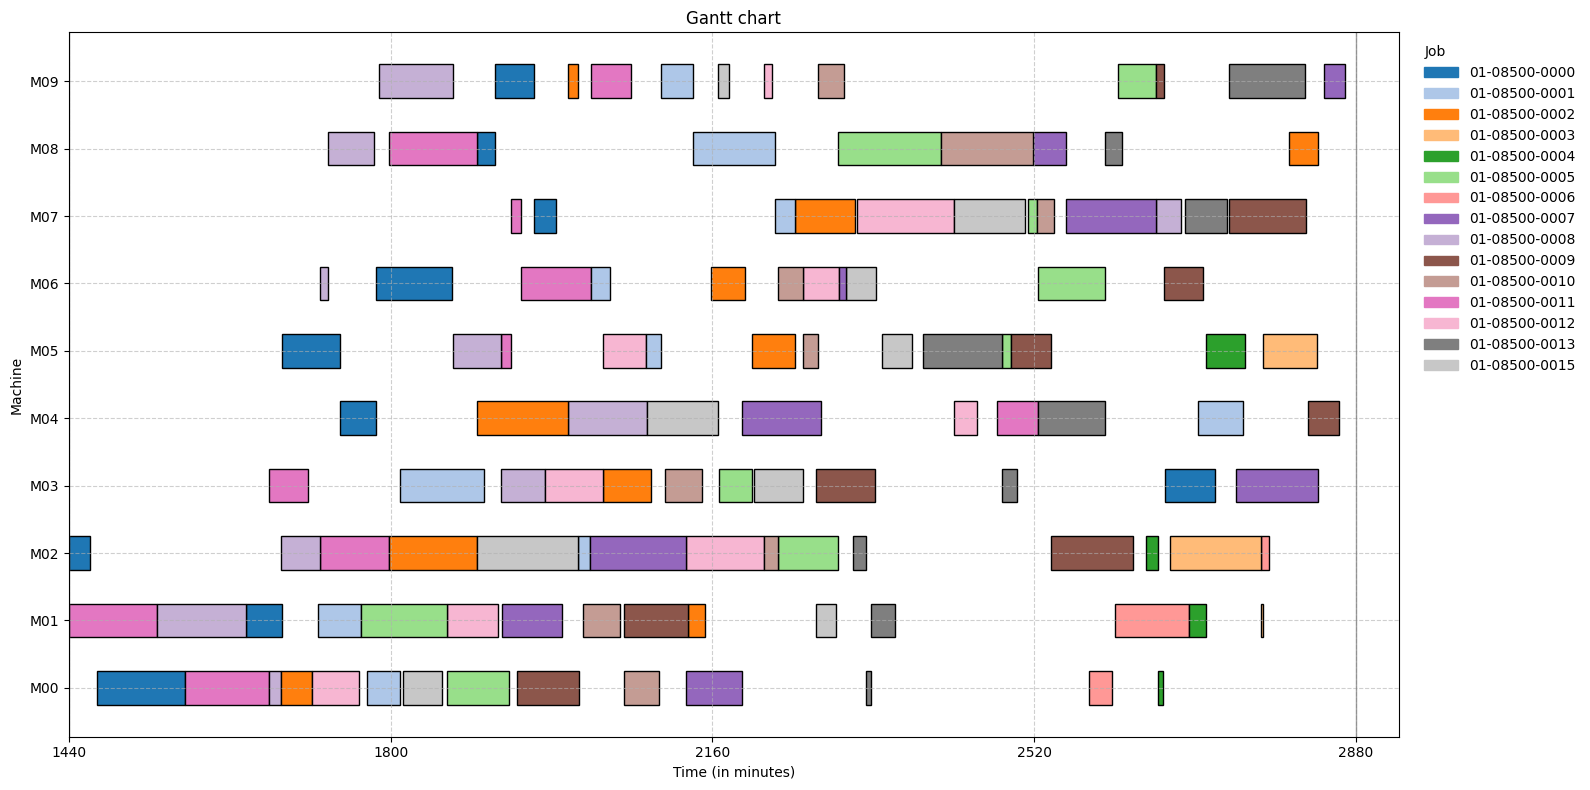

In [23]:
DataFramePlotGenerator.get_gantt_chart_figure(df_execution, perspective="Machine")
plt.show()

In [24]:
active_job_ops_collection = simulation.get_active_operation_collection()
df_active = active_job_ops_collection.to_operations_dataframe()
df_active

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0006,01-00,3,M03,2844.0,41.0,2885.0,753,1440,3570


In [25]:
waiting_job_ops_collection = simulation.get_waiting_operation_collection()
waiting_job_ops_collection.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,3,M03,2906,95,3001,174,1440,3912
1,01-08500-0003,01-05,4,M08,3133,48,3181,174,1440,3912
2,01-08500-0003,01-05,5,M09,3181,72,3253,174,1440,3912
3,01-08500-0003,01-05,6,M00,3253,47,3300,174,1440,3912
4,01-08500-0003,01-05,7,M06,3300,65,3365,174,1440,3912
5,01-08500-0003,01-05,8,M04,3365,6,3371,174,1440,3912
...,...,...,...,...,...,...,...,...,...,...
30,01-08500-0014,01-09,5,M09,3253,76,3329,1210,1440,4277
31,01-08500-0014,01-09,6,M05,3379,47,3426,1210,1440,4277
32,01-08500-0014,01-09,7,M03,3426,52,3478,1210,1440,4277


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [26]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [27]:
# New and previous jobs that must be scheduled
current_jobs_collection_temp = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)
current_jobs_collection = current_jobs_collection_temp + waiting_job_ops_collection

In [28]:
# Test
current_jobs_collection_temp.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0016,01-07,0,M02,None,31,None,1504,2880,4447
1,01-08500-0016,01-07,1,M00,None,86,None,1504,2880,4447
2,01-08500-0016,01-07,2,M01,None,46,None,1504,2880,4447
3,01-08500-0016,01-07,3,M05,None,74,None,1504,2880,4447
4,01-08500-0016,01-07,4,M04,None,32,None,1504,2880,4447
5,01-08500-0016,01-07,5,M06,None,88,None,1504,2880,4447
...,...,...,...,...,...,...,...,...,...,...
204,01-08500-0036,01-03,4,M06,None,9,None,2811,2880,4882
205,01-08500-0036,01-03,5,M08,None,52,None,2811,2880,4882
206,01-08500-0036,01-03,6,M07,None,85,None,2811,2880,4882


In [29]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,3,M03,2906.0,95,3001.0,174,1440,3912
1,01-08500-0003,01-05,4,M08,3133.0,48,3181.0,174,1440,3912
2,01-08500-0003,01-05,5,M09,3181.0,72,3253.0,174,1440,3912
3,01-08500-0003,01-05,6,M00,3253.0,47,3300.0,174,1440,3912
4,01-08500-0003,01-05,7,M06,3300.0,65,3365.0,174,1440,3912
5,01-08500-0003,01-05,8,M04,3365.0,6,3371.0,174,1440,3912
...,...,...,...,...,...,...,...,...,...,...
240,01-08500-0036,01-03,4,M06,NaN,9,NaN,2811,2880,4882
241,01-08500-0036,01-03,5,M08,NaN,52,NaN,2811,2880,4882
242,01-08500-0036,01-03,6,M07,NaN,85,NaN,2811,2880,4882


### Scheduling (Rescheduling)

In [30]:
previous_schedule_jobs_collection = schedule_jobs_collection
df_previous_schedule = previous_schedule_jobs_collection.to_operations_dataframe()

#### a) Simple Scheduling

In [31]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)
solver.build_model_for_jssp_lateness_with_start_deviation_minimization(
    previous_schedule_jobs_collection=None,         # simple scheduling
    active_jobs_collection=active_job_ops_collection,
    w_t = 5, w_e = 1, w_first = 1,
    duration_buffer_factor= 2.5
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

log_file_path = logs_path / "cp_lateness_with_w_first_2_simple.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))


w_t=5, w_e=1, w_first=1 main_pct=1.0
{
  "number_of_operations_to_schedule": 246,
  "number_of_operations_with_previous_schedule": 0,
  "number_of_active_operation_to_consider": 1,
  "number_of_variables": 689,
  "number_of_constraints": 700
}
{
  "status": "OPTIMAL",
  "objective_value": 22.0,
  "best_objective_bound": 22.0,
  "number_of_branches": 34,
  "wall_time": 0.29
}


In [32]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_02_simple.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,3,M03,3017,95,3112,174,1440,3912
1,01-08500-0003,01-05,4,M08,3112,48,3160,174,1440,3912
2,01-08500-0003,01-05,5,M09,3160,72,3232,174,1440,3912
3,01-08500-0003,01-05,6,M00,3244,47,3291,174,1440,3912
4,01-08500-0003,01-05,7,M06,3332,65,3397,174,1440,3912
5,01-08500-0003,01-05,8,M04,3397,6,3403,174,1440,3912
...,...,...,...,...,...,...,...,...,...,...
240,01-08500-0036,01-03,4,M06,4068,9,4077,2811,2880,4882
241,01-08500-0036,01-03,5,M08,4077,52,4129,2811,2880,4882
242,01-08500-0036,01-03,6,M07,4458,85,4543,2811,2880,4882


In [33]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 6 (over 36 shared operations)
Mean Kendall Tau: 0.92


In [34]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,1,31,0,0,0


### b) with 'start' deviation penalty

In [35]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)
solver.build_model_for_jssp_lateness_with_start_deviation_minimization(
    previous_schedule_jobs_collection=previous_schedule_jobs_collection,
    active_jobs_collection=active_job_ops_collection,
    w_t = 5, w_e = 1, w_first = 1,
    main_pct= (1/3),
    duration_buffer_factor= 2.5
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

log_file_path = logs_path / "cp_lateness_with_w_first_2_dev.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))

w_t=5, w_e=1, w_first=1 main_pct=0.3333333333333333
{
  "number_of_operations_to_schedule": 246,
  "number_of_operations_with_previous_schedule": 160,
  "number_of_active_operation_to_consider": 1,
  "number_of_variables": 725,
  "number_of_constraints": 736
}
{
  "status": "OPTIMAL",
  "objective_value": 364.0,
  "best_objective_bound": 364.0,
  "number_of_branches": 78,
  "wall_time": 0.47
}


In [36]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_02_dev.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,3,M03,2911,95,3006,174,1440,3912
1,01-08500-0003,01-05,4,M08,3133,48,3181,174,1440,3912
2,01-08500-0003,01-05,5,M09,3184,72,3256,174,1440,3912
3,01-08500-0003,01-05,6,M00,3256,47,3303,174,1440,3912
4,01-08500-0003,01-05,7,M06,3303,65,3368,174,1440,3912
5,01-08500-0003,01-05,8,M04,3368,6,3374,174,1440,3912
...,...,...,...,...,...,...,...,...,...,...
240,01-08500-0036,01-03,4,M06,4572,9,4581,2811,2880,4882
241,01-08500-0036,01-03,5,M08,4581,52,4633,2811,2880,4882
242,01-08500-0036,01-03,6,M07,4633,85,4718,2811,2880,4882


In [37]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

,Original Sequence,Revised Sequence,Levenshtein,Kendall Tau
Machine,,,,
M00,"[01-08500-0014, 01-08500-0003]","[01-08500-0014, 01-08500-0003]",0,1.0
M01,[01-08500-0014],[01-08500-0014],0,1.0
M02,[01-08500-0014],[01-08500-0014],0,1.0
M03,"[01-08500-0004, 01-08500-0003, 01-08500-0014]","[01-08500-0004, 01-08500-0003, 01-08500-0014]",0,1.0
M04,"[01-08500-0006, 01-08500-0004, 01-08500-0010, ...","[01-08500-0006, 01-08500-0004, 01-08500-0010, ...",0,1.0
M05,"[01-08500-0006, 01-08500-0007, 01-08500-0014]","[01-08500-0006, 01-08500-0007, 01-08500-0014]",0,1.0
M06,"[01-08500-0006, 01-08500-0014, 01-08500-0013, ...","[01-08500-0006, 01-08500-0014, 01-08500-0013, ...",0,1.0
M07,"[01-08500-0006, 01-08500-0004, 01-08500-0003, ...","[01-08500-0006, 01-08500-0004, 01-08500-0003, ...",0,1.0
M08,"[01-08500-0012, 01-08500-0004, 01-08500-0015, ...","[01-08500-0012, 01-08500-0004, 01-08500-0015, ...",0,1.0


In [38]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 0 (over 36 shared operations)
Mean Kendall Tau: 1.00


In [39]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,1,30,1,0,0


#### Check the conditions of the combined data set from the simulation data with the new schedule

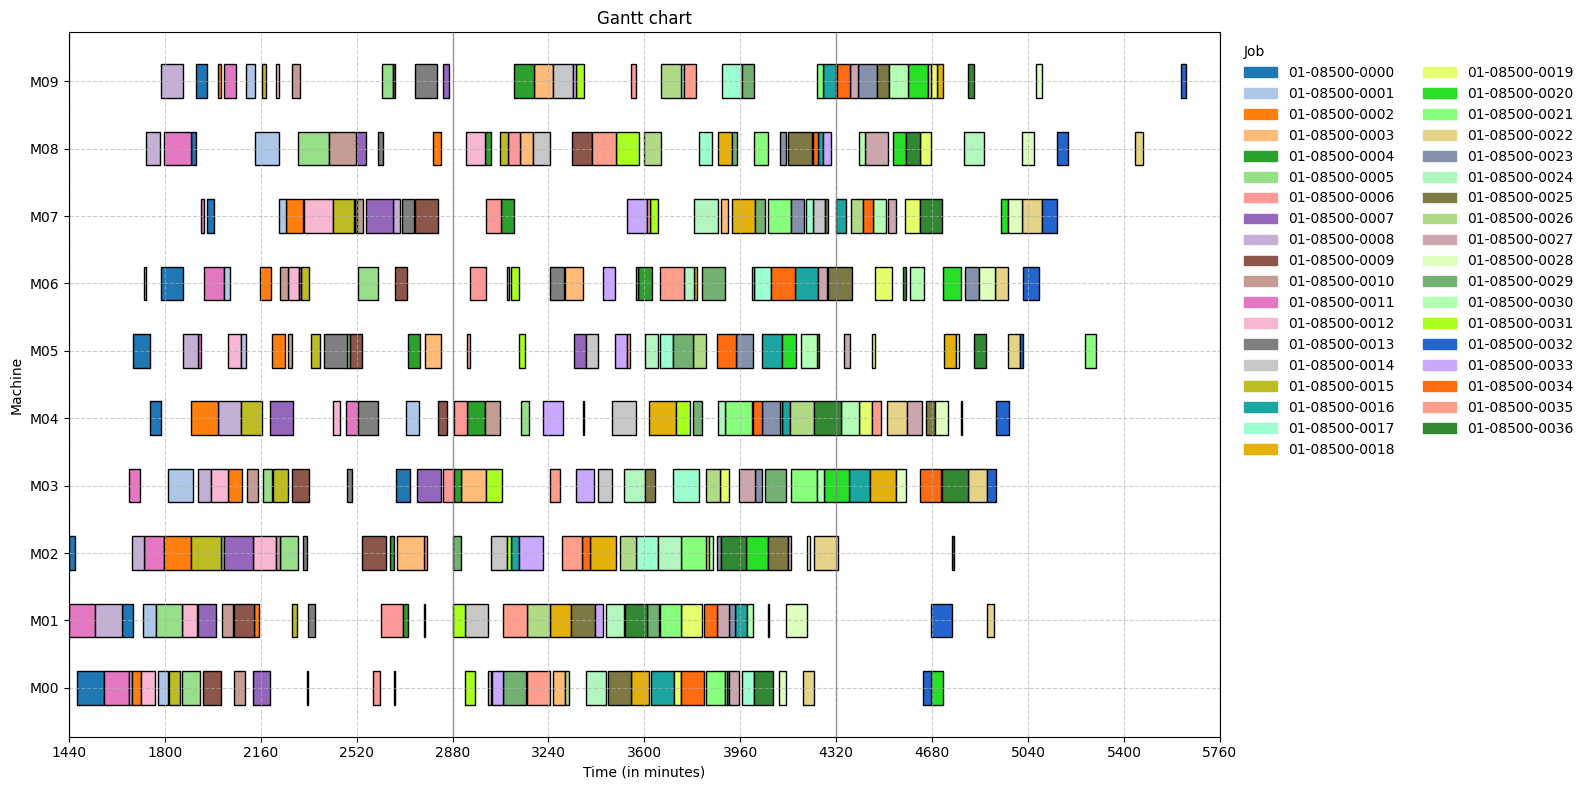

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.


True

In [40]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
DataFramePlotGenerator.get_gantt_chart_figure(df_combined, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_combined)

### Simulation

In [42]:
simulation.run(schedule_collection=schedule_jobs_collection, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job 01-08500-0006, Operation 3 resumed on M03 with 05 minutes left)
[Day 2 00:00:00] Job 01-08500-0029 started on M02
[Day 2 00:00:00] Job 01-08500-0031 started on M01
[Day 2 00:05:00] Job 01-08500-0006 finished on M03 (after 05 minutes)
[Day 2 00:05:00] Job 01-08500-0006 started on M04
[Day 2 00:05:00] Job 01-08500-0004 started on M03
[Day 2 00:20:00] Job 01-08500-0029 finished on M02 (after 20 minutes)
[Day 2 00:38:00] Job 01-08500-0004 finished on M03 (after 33 minutes)
[Day 2 00:38:00] Job 01-08500-0003 started on M03
[Day 2 00:44:00] Job 01-08500-0006 finished on M04 (after 39 minutes)
[Day 2 00:49:00] Job 01-08500-0012 started on M08
[Day 2 00:53:00] Job 01-08500-0031 finished on M01 (after 53 minutes)
[Day 2 00:53:00] Job 01-08500-0014 started on M01
[Day 2 00:53:00] Job 01-08500-0031 started on M00
[Day 2 00:54:00] Job 01-08500-0004 started on M04
[Day 2 00:54:00] Job 01-08500-0006 started on M05
[Day 2 01:03:00] Job 01-08500-0006 finished on M05 (after 09 minu

In [44]:
finished_job_ops_collection2 = simulation.get_finished_operation_collection()
df_execution2 = finished_job_ops_collection2.to_operations_dataframe()

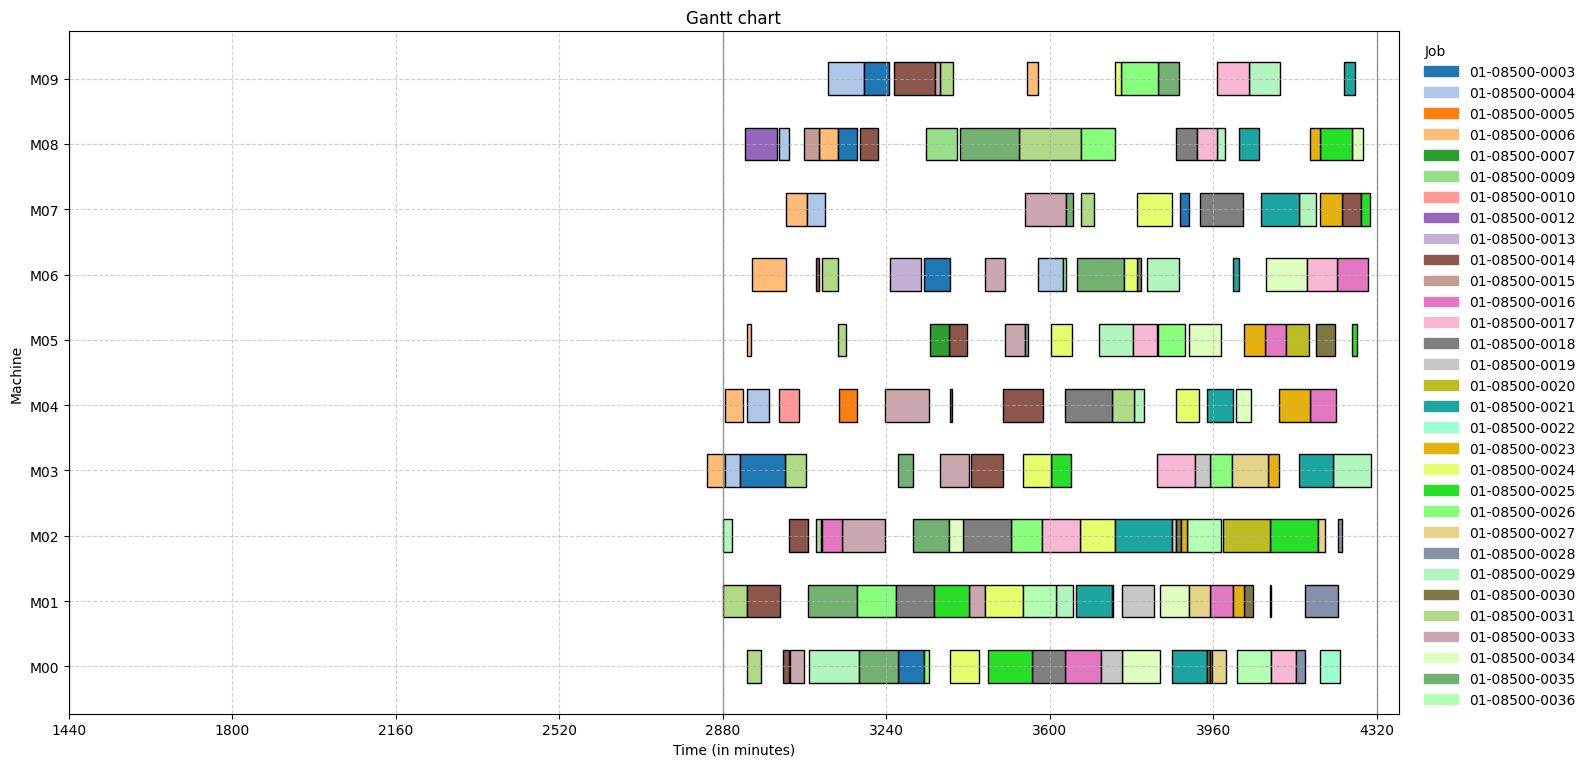

In [45]:
DataFramePlotGenerator.get_gantt_chart_figure(df_execution2, perspective="Machine")
plt.show()

#### Check the conditions of the combined data set from the two simulation data sets

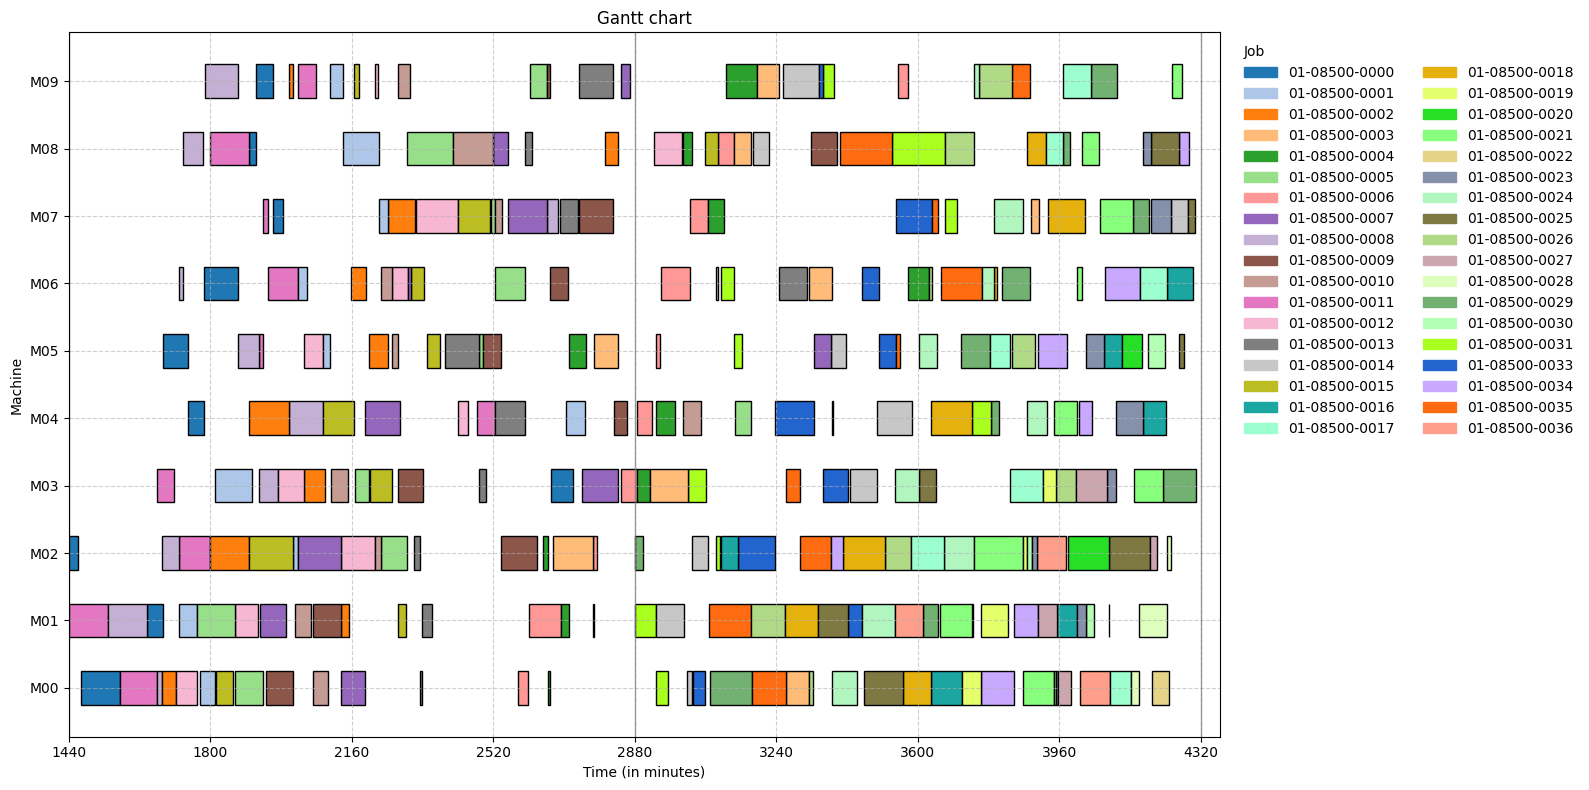

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.


True

In [47]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
DataFramePlotGenerator.get_gantt_chart_figure(df_combined, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_combined)